# Milestone 1

**Dubien** Victor

**Felber** Arnaud

**Preto** Anne-Valérie

_What is your suggested way of processing this problem? That is, which type of an
approach would you use?_

We tried a few approach to understand the problem. 
We are going to present the two approaches that gave us the best results. 
The first one consists of gradient boosting. It uses the concept of decision tree to create the most accurate prediction possible. 
Our second approach to this problem was to build a __Neural Network__. We started on a Three-Layer-Net basis. We then tried to improve it as much as possible.

If you run the notebook, it won't predict with the GradientBoosting, but only with the Neural Network. 
The GradientBoosting part is commented. (We advise you to run only the HistGradientBoosting)

In [ ]:
# Function to align all tables to the left (useful for later on)
#Par soucis de lisibilité, pris des différentes séries 😄 #

In [ ]:
%%html
<style>
table {float:left}
</style>

In [ ]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import helpers
import metrics
import seaborn as sn
from typing import Any, Callable

#imports for the GradientBoosting
from sklearn import datasets
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor


#imports for the NN
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from tqdm.auto import tqdm

from ipywidgets import IntProgress

## 1. Data loading &amp; pre-processing

_What do the features of the dataset look like? How can you pre-process this data?_

__Train and Validation set__
- There's Spectral accelerations, Sa(T), computed at 105 different periods ranging from 0.01s up to
10s. 
- Average spectral accelerations, Saavg, in units of g.
- There's two different measures of ground motion durations (da5_75 and da5_95) in units of seconds. It's important to know how long the ground shaking last.  It damages more the structure the longer it lasts.
- There's also a filtered incremental velocity, FIV3 (units: cm/s)
- We can see the output as the
collapse capacities (sat1_col) of a 4-story steel structure computed for those ground
motions, which is also included in the files.

__Test set__

We believe the test set is to use at the end of our code with the best method we found on the train and validation set. Only the features are available, we are going to predict the output.

_Pre-processing the data :_

First we will import our data and compare it. We need to check the number of columns each data set has. 
It seems to us that there is a large number of features. We have chosen to correlate some of these features. 
This will allow us to gain computational speed and avoid overfit. 
We also need to separate the data between the inputs and outputs, i.e. the 110 features and the output (collapse capacities).
For the following, we are already planning a normalised data on the train. We will therefore be able to compare normalised or non-normalised data, correlated or not.


In [ ]:
#import our data in panda
train_df = pd.read_csv('data/train_set.csv') 
val_df = pd.read_csv('data/val_set.csv')
test_df = pd.read_csv('data/test_set.csv')

In [1]:
#visualize a few to have an idea
train_df.head(5)

NameError: name 'train_df' is not defined

_Do the trends in the data make sense in your opinion and given your current understanding of the effect of earthquakes on the structures? For instance, what does
your intuition tell you the effect of ground motion duration (i.e. how long the earthquake shaking lasts) would be on the collapse capacity of the ground motion?_

It is complicated to say. Our intuition would say that the larger da5_75 and da5_95 is, the greater the chances of collapse. However, this does not seem to be directly related. There are more parameters to be taken into account.
The way in which the acceleration takes place is also important.
We notice, however, that the acceleration rises very slowly. We wonder if the curve is not logarithmic. We tried to 

In [ ]:
#correlation matrix
#we make sure we don't lose the output
features = train_df.drop(columns="sat1_col")
corrMatrix = features.corr(method='pearson')

In [ ]:
#print(corrMatrix)

<AxesSubplot:>

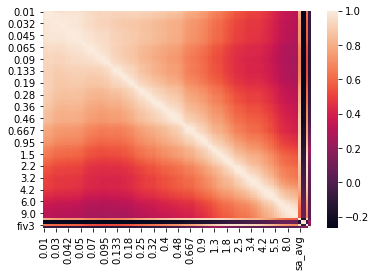

In [ ]:
sn.heatmap(corrMatrix ) #how the data is correlated

In [ ]:
#we can play with the parameter 0.995
columns = np.full((corrMatrix.shape[0],), True, dtype = bool)
for i in range(corrMatrix.shape[0]) :
    for j in range(i, corrMatrix.shape[0]) :
        if (corrMatrix.iloc[i,j] >= 0.995 or corrMatrix.iloc[i,j] <= -0.995) and (i != j) :
            if columns[j] :
                columns[j] = False

#we want to be sure to use the same columns in train,val and test
selected_columns = features.columns[columns] 

features = features[selected_columns]

In [ ]:
#"new" train set = features + sat1_col
features["sat1_col"] = train_df["sat1_col"]
train_data_corr = features
train_data_corr.head(5)


,0.01,0.02,0.029,0.035,0.04,0.055,0.06,0.065,0.075,0.08,...,6.0,6.5,7.0,7.5,sa_avg,da5_75,da5_95,fiv3,sa_ratio,sat1_col
0,0.011075,0.011107,0.011274,0.011377,0.011567,0.011414,0.011530,0.011936,0.012813,0.013878,...,0.000770,0.000648,0.000472,0.000327,0.010809,14.484,21.416,2.881797,0.832237,0.78
1,0.155380,0.153050,0.161038,0.166164,0.174708,0.267167,0.320194,0.403354,0.720102,0.777174,...,0.004932,0.004220,0.003590,0.003106,0.031044,14.430,18.270,7.642059,0.961638,1.96
2,0.060774,0.060783,0.060799,0.060794,0.060798,0.060856,0.060876,0.060817,0.060745,0.061300,...,0.031844,0.029457,0.024209,0.019664,0.098425,16.700,35.105,42.218868,1.737888,1.39
3,0.016016,0.016088,0.016198,0.016401,0.016595,0.016825,0.017284,0.018175,0.018670,0.020036,...,0.000389,0.000367,0.000316,0.000262,0.010169,7.320,17.370,2.599605,1.000551,1.97
4,0.030632,0.030699,0.030785,0.030818,0.031014,0.031411,0.031684,0.031648,0.031708,0.031599,...,0.007108,0.007951,0.007953,0.006537,0.037375,28.005,41.635,11.434507,1.371310,1.43


In [ ]:
#We use the train correlation to have the same columns on the validation set. 
#Be careful, it is necessary to remove the output before.

features_val = val_df.drop(columns="sat1_col")
selected_columns_val = features_val.columns[columns]

# add the output
features_val = features_val[selected_columns_val]
features_val["sat1_col"] = val_df["sat1_col"]
val_data_corr = features_val

In [ ]:
#test correlation
selected_columns_test = test_df.columns[columns]

test_data_corr = test_df[selected_columns_test]

In [ ]:
##preprocessing the data into a numpy ndarray
train_data = train_df.to_numpy()
test_data = test_df.to_numpy()
val_data = val_df.to_numpy()

train_data_corr = train_data_corr.to_numpy()
val_data_corr = val_data_corr.to_numpy()
test_data_corr = test_data_corr.to_numpy()

In [ ]:
#from np to torch tensors
train_data_t = torch.from_numpy(train_data)
test_data_t = torch.from_numpy(test_data)
val_data_t = torch.from_numpy(val_data)
print(train_data.shape)

(12646, 111)


In [ ]:
#Shape of the correlate data set (so we can change the correlation without changing the code)
S= train_data_corr.shape
N=S[1]-1
print(N)

77


In [ ]:

##splitting the ndarrays to get the inputs and the ouputs

# after training a while, we figured the best way to have linear features
# was to take the log. We tried with exponential or log, log was the best one (as expected)

X_train = train_data[:, :110]
X_train = np.log(X_train)
y_train = train_data[:, 110]

X_train_corr = train_data_corr[:, :N]
X_train_corr = np.log(X_train_corr)
y_train_corr = train_data_corr[:, N]

print(f'Shape of X_train: {X_train.shape}')
print(f'Shape of y_train: {y_train.shape}')
print(f'Shape of X_train_corr: {X_train_corr.shape}')
print(f'Shape of y_train_corr: {y_train_corr.shape}')

Shape of X_train: (12646, 110)
Shape of y_train: (12646,)
Shape of X_train_corr: (12646, 77)
Shape of y_train_corr: (12646,)


In [ ]:
X_val = val_data[:, :110]
X_val =np.log(X_val)
y_val = val_data[:, 110]

X_val_corr = val_data_corr[:, :N]
X_val_corr = np.log(X_val_corr)
y_val_corr = val_data_corr[:, N]
print(f'Shape of X_val: {X_val.shape}')
print(f'Shape of y_val: {y_val.shape}')
print(f'Shape of X_val_corr: {X_val_corr.shape}')
print(f'Shape of y_val_corr: {y_val_corr.shape}')

Shape of X_val: (1500, 110)
Shape of y_val: (1500,)
Shape of X_val_corr: (1500, 77)
Shape of y_val_corr: (1500,)


In [ ]:
X_test = test_data[:, :110]
X_test =np.log(X_test)

X_test_corr = test_data_corr[:, :N]
X_test_corr = np.log(X_test_corr)
print(f'Shape of X_test: {X_test.shape}')
print(f'Shape of X_test_corr: {X_test_corr.shape}')

Shape of X_test: (3000, 110)
Shape of X_test_corr: (3000, 77)


In [ ]:
##implementing the normalization function for the non-correlate data and the correlate one

mean = X_train.mean(axis=0)
std = X_train.std(axis=0)

mean_c=X_train_corr.mean(axis=0)
std_c = X_train_corr.std(axis=0)

def normalize(X: np.ndarray, mean: np.ndarray, std: np.ndarray):
    X_normalized = (X-mean)/std
    return X_normalized

##normalizing the data
X_train = normalize(X_train, mean, std)
X_val = normalize(X_val, mean, std)
X_test = normalize(X_test, mean, std)

X_train_corr = normalize(X_train_corr, mean_c, std_c)
X_val_corr = normalize(X_val_corr, mean_c, std_c)
X_test_corr = normalize(X_test_corr, mean_c, std_c)

Our data is now ready to be used. It has been correlated or not, separated into input and output. 
We have also applied the logarithm to the inputs. 
Finally, it has been normalised. 
We can then use the correlated data for GradientBoosting to gain computational speed.

## 2. Gradient Boosting

The principle of Gradient Boosting is to use Decision Trees. 
It will create several different trees with different parameters and try to predict as best as possible what is required. 
To use this technique, we need to "fit" the function to our train data. This does not give us an MSE value.
Then predict on the value and get an idea of the errors by comparing it with the output. 

We initially used Gradient Boosting but it takes too long to run, which is why we commented it. We advise you to run __HistGradientBoosting__ instead.

In [ ]:
#use of the GradientBoosting (slow compared to the HistGradientBoosting)
#better with few features -> correlation

gbr = GradientBoostingRegressor(loss='ls', 
learning_rate=0.05, 
n_estimators=500, 
criterion='friedman_mse')

#gbr.fit(X_train_corr, y_train)
#ypred = gbr.predict(X_val_corr)
#mse1 = mean_squared_error(y_val,ypred)
#print("MSE: %.4f" % mse1)

In [ ]:
#y_test=gbr.predict(X_test_corr)
#np.savetxt('GradientBoosting8.csv', y_test, delimiter = ',')

In [ ]:
reg=HistGradientBoostingRegressor(loss='least_squares', 
learning_rate=0.005, 
max_iter=800, max_leaf_nodes=20, 
max_depth=30, min_samples_leaf=100)

#reg.fit(X_train_corr,y_train) #take out the # to run the gradient boosting

#y_hat=reg.predict(X_val_corr)

#mse=mean_squared_error(y_val,y_hat)
#print("MSE: %.4f" % mse)

In [ ]:
#y_Htest=reg.predict(X_test_corr)
#np.savetxt('HGB1468.csv', y_Htest, delimiter = ',', header='sat1_col')

Be careful, we always check the csv on excel.

_Description of the parameters_

- __learning_rate__ 
float, default=0.1
The learning rate, also known as shrinkage. This is used as a multiplicative factor for the leaves values. Use 1 for no shrinkage.

- __max_iter__
int, default=100
The maximum number of iterations of the boosting process, i.e. the maximum number of trees.

- __max_leaf_nodes__ 
int or None, default=31
The maximum number of leaves for each tree. Must be strictly greater than 1. If None, there is no maximum limit.

- __max_depth__ 
int or None, default=None
The maximum depth of each tree. The depth of a tree is the number of edges to go from the root to the deepest leaf. Depth isn’t constrained by default.

- __min_samples_leaf__ 
int, default=20
The minimum number of samples per leaf. For small datasets with less than a few hundred samples, it is recommended to lower this value since only very shallow trees would be built.

## 3. Neural Network

We want to use our X_train on which we have applied the logarithm and normalized the inputs. However, to be able to use the batch correctly, we must have the inputs and outputs on the same tensor. To do this, without making a mistake, we will use panda again.

In [ ]:
# to panda
X_train=pd.DataFrame(X_train)
X_val=pd.DataFrame(X_val)
X_test=pd.DataFrame(X_test)

In [ ]:
# add the output so it doesn't get lost in the batch
X_train['sat1_col']=train_df['sat1_col']
X_val['sat1_col']=val_df['sat1_col']

train_data_new=X_train
val_data_new=X_val
test_data_new=X_test

In [ ]:
# to torch

train_data = torch.from_numpy(train_data_new.to_numpy())
val_data = torch.from_numpy(val_data_new.to_numpy())
test_data = torch.from_numpy(test_data_new.to_numpy())

In [ ]:
#DataLoader
batch_size = 128
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=False)

In [ ]:
class ThreeLayerNet(nn.Module) :
    def __init__(self) :
        super().__init__()
        self.fc1 = nn.Linear(110, 30) 
        self.fc2 = nn.Linear(30, 30)
        self.fc3 = nn.Linear(30,1)
        self.norm1= nn.BatchNorm1d(num_features=110, eps=1e-08, momentum=0.1)
        self.norm2= nn.BatchNorm1d(num_features=30, eps=1e-08, momentum=0.1)
        self.drop = nn.Dropout(p=0.1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.norm1(x)
        x = F.relu(self.fc1(x))
        x = self.norm2(x)
        x = F.relu(self.fc2(x))
        x = self.drop(x)
        out = self.fc3(x)
        return out

    def predict(self, x: torch.Tensor) -> torch.Tensor:
        pred = self.forward(x)
        return pred
        
model = ThreeLayerNet()

We kept the basic structure of a Three-Layer Net. 
Then we tried to improve it by adding normalization on each batch.
To avoid overfitting, we also added a dropout that randomly removes some variables. If p=0.1, it drops 10% of the parameters.

In [ ]:
#loss function, optimizer & scheduler
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-02, weight_decay=0.0)
scheduler = optim.lr_scheduler.StepLR(optimizer,step_size=30, gamma=0.2)

We used a sufficiently large learning rate at the beginning. Thanks to the scheduler, our learning rate is refined by increasing the number of epochs. 
If the step_size is 30, every 30 epochs it mutliplies the lr by gamma. 

In [ ]:
def train(model: torch.nn.Module, train_loader: torch.utils.data.DataLoader, loss_fn: torch.nn.Module, 
optimizer: torch.optim.Optimizer, epochs: int):

    loss_metric = metrics.LossMetric()

    model.train()

    for epoch in range (1, epochs+1):

        pbar = tqdm(total=len(train_loader), leave=True)
        pbar.set_description(f"Epoch {epoch}")

        for data in train_loader:

            X_train = data[:,:110].reshape(-1,110) # separate inputs and output 
            y_train = data[:, 110].reshape(-1,1)

            optimizer.zero_grad()

            out = model(X_train.float()).reshape(-1,1)

            loss = loss_fn(out, y_train.float())

            loss.backward()

            optimizer.step()

            loss_metric.update(loss.item(), data.shape[0])

            pbar.update()

        scheduler.step() # to change the lr
        print(f"Train loss : {loss_metric.compute():.3f}")

In [ ]:
#Train the model 
train(model, train_loader, loss_fn, optimizer, epochs=150)

  0%|          | 0/99 [00:00<?, ?it/s]

Train loss : 0.323


  0%|          | 0/99 [00:00<?, ?it/s]

Train loss : 0.253


  0%|          | 0/99 [00:00<?, ?it/s]

Train loss : 0.227


  0%|          | 0/99 [00:00<?, ?it/s]

Train loss : 0.212


  0%|          | 0/99 [00:00<?, ?it/s]

Train loss : 0.202


  0%|          | 0/99 [00:00<?, ?it/s]

Train loss : 0.196


  0%|          | 0/99 [00:00<?, ?it/s]

Train loss : 0.191


  0%|          | 0/99 [00:00<?, ?it/s]

Train loss : 0.187


  0%|          | 0/99 [00:00<?, ?it/s]

Train loss : 0.184


  0%|          | 0/99 [00:00<?, ?it/s]

Train loss : 0.181


  0%|          | 0/99 [00:00<?, ?it/s]

Train loss : 0.179


  0%|          | 0/99 [00:00<?, ?it/s]

Train loss : 0.176


  0%|          | 0/99 [00:00<?, ?it/s]

Train loss : 0.175


  0%|          | 0/99 [00:00<?, ?it/s]

Train loss : 0.173


  0%|          | 0/99 [00:00<?, ?it/s]

Train loss : 0.172


  0%|          | 0/99 [00:00<?, ?it/s]

Train loss : 0.171


  0%|          | 0/99 [00:00<?, ?it/s]

Train loss : 0.170


  0%|          | 0/99 [00:00<?, ?it/s]

Train loss : 0.169


  0%|          | 0/99 [00:00<?, ?it/s]

Train loss : 0.168


  0%|          | 0/99 [00:00<?, ?it/s]

Train loss : 0.167


  0%|          | 0/99 [00:00<?, ?it/s]

Train loss : 0.166


  0%|          | 0/99 [00:00<?, ?it/s]

Train loss : 0.165


  0%|          | 0/99 [00:00<?, ?it/s]

Train loss : 0.164


  0%|          | 0/99 [00:00<?, ?it/s]

Train loss : 0.164


  0%|          | 0/99 [00:00<?, ?it/s]

Train loss : 0.163


  0%|          | 0/99 [00:00<?, ?it/s]

Train loss : 0.163


  0%|          | 0/99 [00:00<?, ?it/s]

Train loss : 0.162


  0%|          | 0/99 [00:00<?, ?it/s]

Train loss : 0.162


  0%|          | 0/99 [00:00<?, ?it/s]

Train loss : 0.161


  0%|          | 0/99 [00:00<?, ?it/s]

Train loss : 0.161


  0%|          | 0/99 [00:00<?, ?it/s]

Train loss : 0.160


  0%|          | 0/99 [00:00<?, ?it/s]

Train loss : 0.159


  0%|          | 0/99 [00:00<?, ?it/s]

Train loss : 0.159


  0%|          | 0/99 [00:00<?, ?it/s]

Train loss : 0.158


  0%|          | 0/99 [00:00<?, ?it/s]

Train loss : 0.158


  0%|          | 0/99 [00:00<?, ?it/s]

Train loss : 0.158


  0%|          | 0/99 [00:00<?, ?it/s]

Train loss : 0.157


  0%|          | 0/99 [00:00<?, ?it/s]

Train loss : 0.157


  0%|          | 0/99 [00:00<?, ?it/s]

Train loss : 0.156


  0%|          | 0/99 [00:00<?, ?it/s]

Train loss : 0.156


  0%|          | 0/99 [00:00<?, ?it/s]

Train loss : 0.156


  0%|          | 0/99 [00:00<?, ?it/s]

Train loss : 0.155


  0%|          | 0/99 [00:00<?, ?it/s]

Train loss : 0.155


  0%|          | 0/99 [00:00<?, ?it/s]

Train loss : 0.155


  0%|          | 0/99 [00:00<?, ?it/s]

Train loss : 0.154


  0%|          | 0/99 [00:00<?, ?it/s]

Train loss : 0.154


  0%|          | 0/99 [00:00<?, ?it/s]

Train loss : 0.154


  0%|          | 0/99 [00:00<?, ?it/s]

Train loss : 0.153


  0%|          | 0/99 [00:00<?, ?it/s]

Train loss : 0.153


  0%|          | 0/99 [00:00<?, ?it/s]

Train loss : 0.153


  0%|          | 0/99 [00:00<?, ?it/s]

Train loss : 0.153


  0%|          | 0/99 [00:00<?, ?it/s]

Train loss : 0.152


  0%|          | 0/99 [00:00<?, ?it/s]

Train loss : 0.152


  0%|          | 0/99 [00:00<?, ?it/s]

Train loss : 0.152


  0%|          | 0/99 [00:00<?, ?it/s]

Train loss : 0.152


  0%|          | 0/99 [00:00<?, ?it/s]

Train loss : 0.152


  0%|          | 0/99 [00:00<?, ?it/s]

Train loss : 0.151


  0%|          | 0/99 [00:00<?, ?it/s]

Train loss : 0.151


  0%|          | 0/99 [00:00<?, ?it/s]

Train loss : 0.151


  0%|          | 0/99 [00:00<?, ?it/s]

Train loss : 0.151


  0%|          | 0/99 [00:00<?, ?it/s]

Train loss : 0.151


  0%|          | 0/99 [00:00<?, ?it/s]

Train loss : 0.150


  0%|          | 0/99 [00:00<?, ?it/s]

Train loss : 0.150


  0%|          | 0/99 [00:00<?, ?it/s]

Train loss : 0.150


  0%|          | 0/99 [00:00<?, ?it/s]

Train loss : 0.150


  0%|          | 0/99 [00:00<?, ?it/s]

Train loss : 0.150


  0%|          | 0/99 [00:00<?, ?it/s]

Train loss : 0.149


  0%|          | 0/99 [00:00<?, ?it/s]

Train loss : 0.149


  0%|          | 0/99 [00:00<?, ?it/s]

Train loss : 0.149


  0%|          | 0/99 [00:00<?, ?it/s]

Train loss : 0.149


  0%|          | 0/99 [00:00<?, ?it/s]

Train loss : 0.149


  0%|          | 0/99 [00:00<?, ?it/s]

Train loss : 0.149


  0%|          | 0/99 [00:00<?, ?it/s]

Train loss : 0.148


  0%|          | 0/99 [00:00<?, ?it/s]

Train loss : 0.148


  0%|          | 0/99 [00:00<?, ?it/s]

Train loss : 0.148


  0%|          | 0/99 [00:00<?, ?it/s]

Train loss : 0.148


  0%|          | 0/99 [00:00<?, ?it/s]

Train loss : 0.148


  0%|          | 0/99 [00:00<?, ?it/s]

Train loss : 0.148


  0%|          | 0/99 [00:00<?, ?it/s]

Train loss : 0.148


  0%|          | 0/99 [00:00<?, ?it/s]

Train loss : 0.147


  0%|          | 0/99 [00:00<?, ?it/s]

Train loss : 0.147


  0%|          | 0/99 [00:00<?, ?it/s]

Train loss : 0.147


  0%|          | 0/99 [00:00<?, ?it/s]

Train loss : 0.147


  0%|          | 0/99 [00:00<?, ?it/s]

Train loss : 0.147


  0%|          | 0/99 [00:00<?, ?it/s]

Train loss : 0.147


  0%|          | 0/99 [00:00<?, ?it/s]

Train loss : 0.147


  0%|          | 0/99 [00:00<?, ?it/s]

Train loss : 0.146


  0%|          | 0/99 [00:00<?, ?it/s]

Train loss : 0.146


  0%|          | 0/99 [00:00<?, ?it/s]

Train loss : 0.146


  0%|          | 0/99 [00:00<?, ?it/s]

Train loss : 0.146


  0%|          | 0/99 [00:00<?, ?it/s]

Train loss : 0.146


  0%|          | 0/99 [00:00<?, ?it/s]

Train loss : 0.146


  0%|          | 0/99 [00:00<?, ?it/s]

Train loss : 0.146


  0%|          | 0/99 [00:00<?, ?it/s]

Train loss : 0.146


  0%|          | 0/99 [00:00<?, ?it/s]

Train loss : 0.146


  0%|          | 0/99 [00:00<?, ?it/s]

Train loss : 0.146


  0%|          | 0/99 [00:00<?, ?it/s]

Train loss : 0.145


  0%|          | 0/99 [00:00<?, ?it/s]

Train loss : 0.145


  0%|          | 0/99 [00:00<?, ?it/s]

Train loss : 0.145


  0%|          | 0/99 [00:00<?, ?it/s]

Train loss : 0.145


  0%|          | 0/99 [00:00<?, ?it/s]

Train loss : 0.145


  0%|          | 0/99 [00:00<?, ?it/s]

Train loss : 0.145


  0%|          | 0/99 [00:00<?, ?it/s]

Train loss : 0.145


  0%|          | 0/99 [00:00<?, ?it/s]

Train loss : 0.145


  0%|          | 0/99 [00:00<?, ?it/s]

Train loss : 0.145


  0%|          | 0/99 [00:00<?, ?it/s]

Train loss : 0.145


  0%|          | 0/99 [00:00<?, ?it/s]

Train loss : 0.144


  0%|          | 0/99 [00:00<?, ?it/s]

Train loss : 0.144


  0%|          | 0/99 [00:00<?, ?it/s]

Train loss : 0.144


  0%|          | 0/99 [00:00<?, ?it/s]

Train loss : 0.144


  0%|          | 0/99 [00:00<?, ?it/s]

Train loss : 0.144


  0%|          | 0/99 [00:00<?, ?it/s]

Train loss : 0.144


  0%|          | 0/99 [00:00<?, ?it/s]

Train loss : 0.144


  0%|          | 0/99 [00:00<?, ?it/s]

Train loss : 0.144


  0%|          | 0/99 [00:00<?, ?it/s]

Train loss : 0.144


  0%|          | 0/99 [00:00<?, ?it/s]

Train loss : 0.144


  0%|          | 0/99 [00:00<?, ?it/s]

Train loss : 0.144


  0%|          | 0/99 [00:00<?, ?it/s]

Train loss : 0.144


  0%|          | 0/99 [00:00<?, ?it/s]

Train loss : 0.144


  0%|          | 0/99 [00:00<?, ?it/s]

Train loss : 0.144


  0%|          | 0/99 [00:00<?, ?it/s]

Train loss : 0.143


  0%|          | 0/99 [00:00<?, ?it/s]

Train loss : 0.143


  0%|          | 0/99 [00:00<?, ?it/s]

Train loss : 0.143


  0%|          | 0/99 [00:00<?, ?it/s]

Train loss : 0.143


  0%|          | 0/99 [00:00<?, ?it/s]

Train loss : 0.143


  0%|          | 0/99 [00:00<?, ?it/s]

Train loss : 0.143


  0%|          | 0/99 [00:00<?, ?it/s]

Train loss : 0.143


  0%|          | 0/99 [00:00<?, ?it/s]

Train loss : 0.143


  0%|          | 0/99 [00:00<?, ?it/s]

Train loss : 0.143


  0%|          | 0/99 [00:00<?, ?it/s]

Train loss : 0.143


  0%|          | 0/99 [00:00<?, ?it/s]

Train loss : 0.143


  0%|          | 0/99 [00:00<?, ?it/s]

Train loss : 0.143


  0%|          | 0/99 [00:00<?, ?it/s]

Train loss : 0.143


  0%|          | 0/99 [00:00<?, ?it/s]

Train loss : 0.143


  0%|          | 0/99 [00:00<?, ?it/s]

Train loss : 0.143


  0%|          | 0/99 [00:00<?, ?it/s]

Train loss : 0.143


  0%|          | 0/99 [00:00<?, ?it/s]

Train loss : 0.142


  0%|          | 0/99 [00:00<?, ?it/s]

Train loss : 0.142


  0%|          | 0/99 [00:00<?, ?it/s]

Train loss : 0.142


  0%|          | 0/99 [00:00<?, ?it/s]

Train loss : 0.142


  0%|          | 0/99 [00:00<?, ?it/s]

Train loss : 0.142


  0%|          | 0/99 [00:00<?, ?it/s]

Train loss : 0.142


  0%|          | 0/99 [00:00<?, ?it/s]

Train loss : 0.142


  0%|          | 0/99 [00:00<?, ?it/s]

Train loss : 0.142


  0%|          | 0/99 [00:00<?, ?it/s]

Train loss : 0.142


  0%|          | 0/99 [00:00<?, ?it/s]

Train loss : 0.142


  0%|          | 0/99 [00:00<?, ?it/s]

Train loss : 0.142


  0%|          | 0/99 [00:00<?, ?it/s]

Train loss : 0.142


  0%|          | 0/99 [00:00<?, ?it/s]

Train loss : 0.142


  0%|          | 0/99 [00:00<?, ?it/s]

Train loss : 0.142


The visualisation doesn't work very well but the code runs well to the end. 

In [ ]:
def validation(model: torch.nn.Module, val_loader: torch.utils.data.DataLoader):

    loss_metric = metrics.LossMetric()

    pbar = tqdm(total = len(val_loader), leave=True)
    
    model.eval()

    with torch.no_grad():

        for data in val_loader :
            X_val = data[:, :110].reshape(-1, 110)
            y_val = data[:, 110].reshape(-1,1)

            out = model(X_val.float()).reshape(-1,1)

            loss = loss_fn(out, y_val.float())
            loss_metric.update(loss.item(), data.shape[0])

            pbar.update()

    print(f"Loss : {loss_metric.compute():.4f}")

validation(model, val_loader)

  0%|          | 0/12 [00:00<?, ?it/s]

Loss : 0.1343


In [ ]:
#output
predictions = model.predict(test_data.float()).reshape(-1,1)
print(predictions)
predictions.type()

tensor([[0.5293],
        [1.1697],
        [1.4241],
        ...,
        [0.9800],
        [1.2310],
        [1.8558]], grad_fn=<ViewBackward>)


'torch.FloatTensor'

In [ ]:
np_pred = predictions.cpu().detach().numpy()

In [ ]:
#converting numpy predictions to CSV
np.savetxt('NN1340.csv', np_pred, delimiter=',', header='sat1_col')

### 4. Discussion

_Which machine learning techniques did you try? Which of them worked the best, and
why do you think this is the case?_

We tried several techniques. 

At first, we tried simple **linear regression** techniques (gradient descent, least square method). This allowed us to become familiar with the data, and to pre-process it. However, this was not precise enough. It did not allow us to pass the 0.160MSE mark for the challenge. 

We then tried to complexify our code. This is when we discovered the **scikit-learn** library. We implemented a KNN which just allowed us to pass the challenge condition, with a MSE of 0.159. We then looked on the internet for a faster and more efficient method. In parallel to the course, we discovered decision trees and became interested in GradientBoosting. The simple version of GradientBoosting cannot have more than 100 parameters, so we had to choose the correlated data. To go even faster, we chose **HistGradientBoosting**, which allowed us to get our best score then on A.I. crowd. (0.152MSE)

We wanted to implement a **Neural Network** from the beginning. So we decided to use a Three-Layer-Net to start with and build on that. 
We used the one we made in class, but we had to change several parameters.   

We decided, given the speed of the test, not to necessarily correlate our base data. 
We therefore left it as is. (We used the correlation for the GradientBoosting)
For the use of the batch size and the shuffle, we had to reconsider how to define our inputs and outputs and to check the sizes.
Contrary to the example in the course, we are doing a linear regression model.
We therefore had to redefine our criteria to be able to observe the _loss_ instead of the accuracy

We added _batchnorms_ to our Neural Network. To normalise the batches and not all the data.
We also added a _dropout_ function to prevent overfitting. 

It also seemed interesting to us to vary the learning rate according to the epoch. 
This is why we used a scheduler. Every 30 or 40 epochs (step_size), 
it makes our learning rate smaller by multiplying it by gamma (=0.1 or 0.2)


_The Neural Network definitely worked better than the other techniques._ 
We thought we reached a maximum accuracy level with the other techniques. GradientBoosting gave us good results, but despite changing the parameters it did not evolve much (MSE around 0.152 on A.I. crowd).
The Neural Network allows us to do more in less time, so it is much more interesting, and thanks to the implementation of two layers of batch normalisation and a scheduler for the train learning rate, we managed to get a 0.139 MSE on A.I. Crowd, while the validation loss was 0.133. After that, however we changed the hyperparameters, we never got better, and we did not find any other implementation to optimize our network.




<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=6a7f4082-30e9-459a-b7a3-b829bab26631' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>